In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv')
df = df[['Price']]
# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Drop missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

# SPLITTING DATA(7-2-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00


In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9962.906, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9956.999, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9957.058, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9957.101, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9955.022, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9958.959, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.807 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5
 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5
 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5 1021.5]


In [ ]:
# Calculate the accuracy for each model

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  92.1578297042729
Testing MAE:  75.90947521865894
Testing MAPE:  8.27653214641173
Validation RMSE:  50.433968591230965
Validation MAE:  41.48872832369942
Validation MAPE:  4.066357662144387


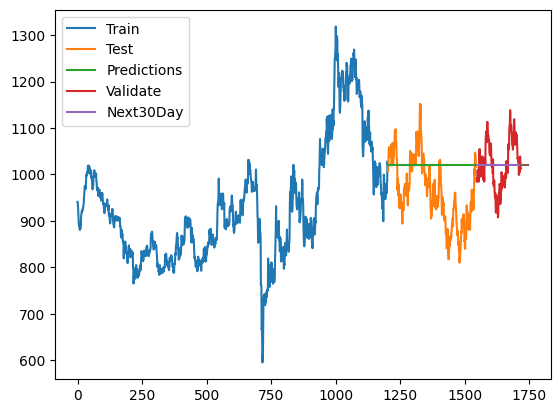

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1202
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4976.511
Date:                Mon, 19 Jun 2023   AIC                           9955.022
Time:                        13:07:33   BIC                           9960.113
Sample:                             0   HQIC                          9956.940
                               - 1202                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       232.6204      5.049     46.073      0.000     222.725     242.516
===================================================================================
Ljung-Box (L1) (Q):                   1.95   Jarque-Bera (JB):              1336.29
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               5.29   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8455.553, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8456.092, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8456.123, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8453.827, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8457.704, Time=0.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.745 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188.
 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188. 1188.
 1188. 1188. 1188. 1188. 1188. 1188.]


In [ ]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  207.6254124339059
Testing MAE:  185.48106796116505
Testing MAPE:  19.50305027401231
Validation RMSE:  173.0263810534753
Validation MAE:  165.51589595375722
Validation MAPE:  16.471683181607943


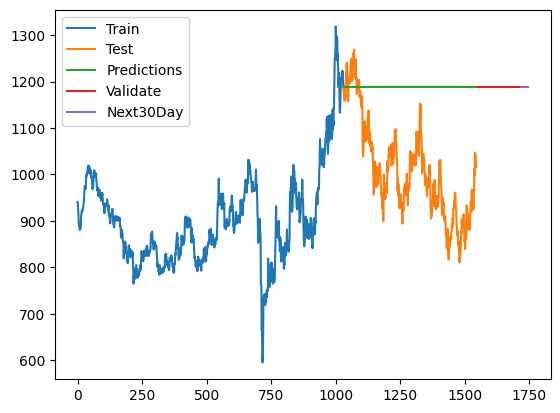

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6880.177, Time=4.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6883.620, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6883.789, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6883.735, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6881.623, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6886.163, Time=1.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6886.139, Time=1.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6881.291, Time=3.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6874.674, Time=7.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6882.906, Time=1.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6875.428, Time=7.34 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6882.087, Time=2.53 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=6877.437, Time=3.16 sec
 ARIMA(2,1,3)(0,0,0)[0]             : 

ARIMA(order=(2, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[956.0066246  950.10053947 946.60049969 945.09442905 945.84057731
 948.68489233 953.09240155 958.24772172 963.20583298 967.06525007
 969.13186886 969.04371989 966.83422153 962.92290714 958.03589963
 953.07118446 948.93366493 946.37028671 945.8352613  947.40969445
 950.78981991 955.3454289  960.23728728 964.57167863 967.56362547
 968.67898947 967.72973862 964.90540662 960.73552872 955.99045202]


In [ ]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  138.9201252936553
Testing MAE:  108.85801428640781
Testing MAPE:  9.804817402290794
Validation RMSE:  75.44146309711549
Validation MAE:  63.20254845442304
Validation MAPE:  6.502330974426906


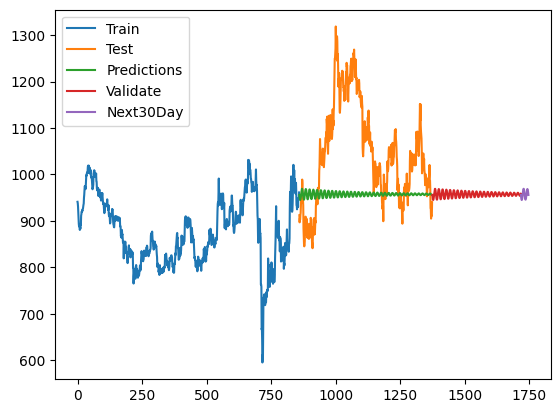

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# Evaluating Model

---

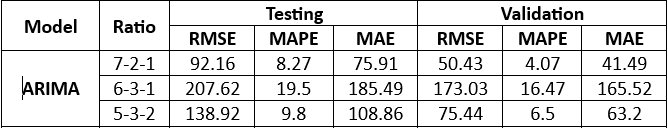